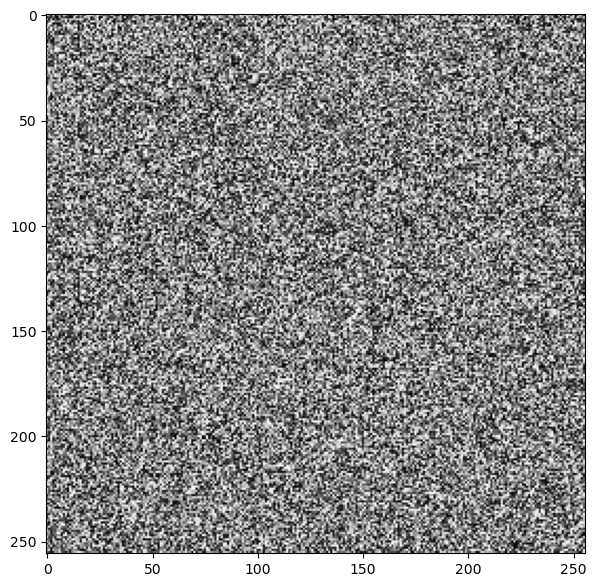

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# generate random numpy array with values from 0 to 255
# and a size of 256x256
random_image = np.random.randint(0, 256, (256, 256))
# initialize plot
plt.figure(figsize=(7, 7))
# show grayscale image, nb: cmap, vmin and vmax
plt.imshow(random_image, cmap='gray', vmin=0, vmax=255)
plt.show()

In [3]:
print(random_image)
print(random_image.shape)

[[250 160   9 ... 232 114   9]
 [ 25  67  36 ... 134 110 207]
 [202   5 191 ...  15  39  81]
 ...
 [132 110  48 ...  53 188  32]
 [149 235   1 ... 213  48 224]
 [104  59  22 ...  10  59 254]]
(256, 256)


In [4]:
print(random_image.flatten())
print(random_image.flatten().shape)

[250 160   9 ...  10  59 254]
(65536,)


In [5]:
"""Script to download all instances in a DICOM Store."""
import os
import posixpath
from concurrent import futures
from retrying import retry
import google.auth
from google.auth.transport.requests import AuthorizedSession

# URL of CHC API
CHC_API_URL = 'https://healthcare.googleapis.com/v1beta1'
PROJECT_ID = 'kaggle-siim-healthcare'
REGION = 'us-central1'
DATASET_ID = 'siim-pneumothorax'
TRAIN_DICOM_STORE_ID = 'dicom-images-train'
TEST_DICOM_STORE_ID = 'dicom-images-test'


@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def download_instance(dicom_web_url, dicom_store_id, study_uid, series_uid,
                      instance_uid, credentials):
    """Downloads a DICOM instance and saves it under the current folder."""
    instance_url = posixpath.join(dicom_web_url, 'studies', study_uid, 'series',
                                  series_uid, 'instances', instance_uid)
    authed_session = AuthorizedSession(credentials)
    response = authed_session.get(
        instance_url, headers={'Accept': 'application/dicom; transfer-syntax=*'})
    file_path = posixpath.join(dicom_store_id, study_uid, series_uid,
                               instance_uid)
    filename = '%s.dcm' % file_path
    if not os.path.exists(filename):
        os.makedirs(os.path.dirname(filename))
    with open(filename, 'wb') as f:
        f.write(response.content)


def download_all_instances(dicom_store_id, credentials):
    """Downloads all DICOM instances in the specified DICOM store."""
    # Get a list of all instances.
    dicom_web_url = posixpath.join(CHC_API_URL, 'projects', PROJECT_ID,
                                   'locations', REGION, 'datasets', DATASET_ID,
                                   'dicomStores', dicom_store_id, 'dicomWeb')
    qido_url = posixpath.join(dicom_web_url, 'instances')
    authed_session = AuthorizedSession(credentials)
    response = authed_session.get(qido_url, params={'limit': '15000'})
    if response.status_code != 200:
        print(response.text)
        return
    content = response.json()
    # DICOM Tag numbers
    study_instance_uid_tag = '0020000D'
    series_instance_uid_tag = '0020000E'
    sop_instance_uid_tag = '00080018'
    value_key = 'Value'
    with futures.ThreadPoolExecutor() as executor:
        future_to_study_uid = {}
        for instance in content:
            study_uid = instance[study_instance_uid_tag][value_key][0]
            series_uid = instance[series_instance_uid_tag][value_key][0]
            instance_uid = instance[sop_instance_uid_tag][value_key][0]
            future = executor.submit(download_instance, dicom_web_url, dicom_store_id,
                                     study_uid, series_uid, instance_uid, credentials)
            future_to_study_uid[future] = study_uid
        processed_count = 0
        for future in futures.as_completed(future_to_study_uid):
            try:
                future.result()
                processed_count += 1
                if not processed_count % 100 or processed_count == len(content):
                    print('Processed instance %d out of %d' %
                          (processed_count, len(content)))
            except Exception as e:
                print('Failed to download a study. UID: %s \n exception: %s' %
                      (future_to_study_uid[future], e))


def main(argv=None):
    credentials, _ = google.auth.default()
    print('Downloading all instances in %s DICOM store' % TRAIN_DICOM_STORE_ID)
    download_all_instances(TRAIN_DICOM_STORE_ID, credentials)
    print('Downloading all instances in %s DICOM store' % TEST_DICOM_STORE_ID)
    download_all_instances(TEST_DICOM_STORE_ID, credentials)


main()


ModuleNotFoundError: No module named 'google'